In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score

In [2]:
liar_data = pd.read_csv('feverous.csv', names=["ID", "label", "claim", "evidence", "annotator_operations", "expected_challenge", "challenge"])

In [3]:
liar_data = liar_data.drop(0)

In [4]:
# Select only the relevant columns for our task
liar_data = liar_data[['claim', 'label']]

In [5]:
# Convert the labels to integers using LabelEncoder
le = LabelEncoder()
liar_data['label'] = le.fit_transform(liar_data['label'])

In [6]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(liar_data, test_size=0.2, random_state=42)

In [7]:
# Tokenize the statements using Keras' Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data['claim'])

In [8]:
# Convert the tokenized sequences to padded sequences
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data['claim']), maxlen=100)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data['claim']), maxlen=100)

In [9]:
# Build the LSTM model
model = Sequential()
model.add(Embedding(5000, 64))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

In [10]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=3)
model.fit(X_train, train_data['label'], batch_size=64, epochs=50, validation_split=0.1, callbacks=[early_stop])

Epoch 1/50
802/802 [==============================] - 119s 146ms/step - loss: 0.8257 - accuracy: 0.5791 - val_loss: 0.7873 - val_accuracy: 0.5861
Epoch 2/50
802/802 [==============================] - 117s 146ms/step - loss: 0.7824 - accuracy: 0.6073 - val_loss: 0.7601 - val_accuracy: 0.6285
Epoch 3/50
802/802 [==============================] - 150s 187ms/step - loss: 0.7420 - accuracy: 0.6392 - val_loss: 0.7519 - val_accuracy: 0.6332
Epoch 4/50
802/802 [==============================] - 160s 199ms/step - loss: 0.7139 - accuracy: 0.6576 - val_loss: 0.7552 - val_accuracy: 0.6352
Epoch 5/50
802/802 [==============================] - 114s 142ms/step - loss: 0.6835 - accuracy: 0.6735 - val_loss: 0.7711 - val_accuracy: 0.6392
Epoch 6/50
802/802 [==============================] - 122s 152ms/step - loss: 0.6557 - accuracy: 0.6881 - val_loss: 0.7977 - val_accuracy: 0.6213


In [12]:
# Evaluate the model on the test set
score, acc = model.evaluate(X_test, test_data['label'], batch_size=64)
print('Test score:', score)
print('Test accuracy:', acc)

223/223 [==============================] - 7s 30ms/step - loss: 0.8170 - accuracy: 0.6109
Test score: 0.8170292973518372
Test accuracy: 0.6109123826026917


In [13]:
# Make predictions on the test set and calculate evaluation metrics
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

446/446 [==============================] - 9s 19ms/step


In [14]:
print(test_data['label'].shape)
print(y_pred.shape)

(14259,)
(14259, 6)


In [15]:
print(classification_report(test_data['label'], y_pred_labels))

              precision    recall  f1-score   support

           0       0.06      0.00      0.00       464
           1       0.53      0.38      0.45      5495
           2       0.64      0.80      0.71      8300

    accuracy                           0.61     14259
   macro avg       0.41      0.39      0.39     14259
weighted avg       0.58      0.61      0.59     14259



Confusion Matrix:
[[   1  146  317]
 [   8 2110 3377]
 [   8 1692 6600]]


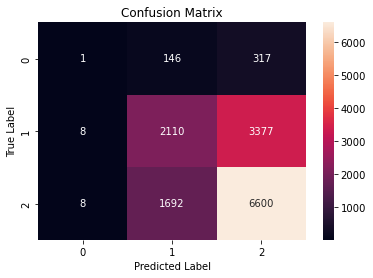

In [16]:
cm = confusion_matrix(test_data['label'], y_pred_labels)
print(f'Confusion Matrix:\n{cm}')
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

C:\Users\shruti29\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\shruti29\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\shruti29\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


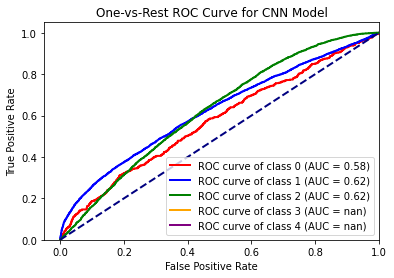

In [18]:
test_data['label'].shape 
y_pred.shape 

n_classes = y_pred.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((test_data['label'] == i).astype(int), y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot one-vs-rest ROC curve for each class
plt.figure()
colors = ['red', 'blue', 'green', 'orange', 'purple'] # customize colors as needed
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curve for CNN Model')
plt.legend(loc="lower right")
plt.show()
